In [1]:
%matplotlib inline

import sys
sys.path.append('..')

import xarray as xr
import numpy as np
from pathlib import Path
from itertools import product
import os
import matplotlib.pyplot as plt



In [2]:
data_dir = Path(os.getenv("DATADIR"))

In [12]:
climatology = xr.open_dataset(data_dir / "SST_CCI_climatology" / "SST_1x1_daily.nc")
cos_lat_weights = np.cos(np.deg2rad(climatology.latitude))

# Use the SST values in the climatology as an ocean mask. Set area to 1 for gridcells with SSTs, 0 otherwise
climatology = climatology.sst[0].values
ocean = np.where(np.isnan(climatology), 0.0, 1.0)

# Areas are proportional to the cosine of latitude multiplied by the ocean area in the grid cell
areas = np.zeros((36, 72))
for xx, yy in product(range(72), range(36)):
    areas[yy, xx] = np.mean(ocean[yy*5:(yy+1)*5, xx*5:(xx+1)*5]) * cos_lat_weights.values[yy*5+2]

# normalise the areas to one at the equator
areas = areas/np.max(areas)

In [13]:
hadsst4 = xr.open_dataset(data_dir / "ManagedData" / "Data" / "HadSST4" / "HadSST.4.1.1.0_median.nc")

lat_slice = hadsst4.tos.sel(latitude=slice(-90, 90))
lat_lon_slice = lat_slice.sel(longitude=slice(-180, 180))

weights = lat_lon_slice[0]
weights.values = areas

h4_weighted_mean = lat_lon_slice.weighted(weights).mean(("longitude", "latitude"))
h4_time = np.arange(len(h4_weighted_mean))/12. + 1850.

In [14]:
oo_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies.nc")

lat_slice = oo_anomalies.sst.sel(latitude=slice(-90, 90))
lat_lon_slice = lat_slice.sel(longitude=slice(-180, 180))

weights = lat_lon_slice[0]
weights.values = areas

oo_weighted_mean = lat_lon_slice.weighted(weights).mean(("longitude", "latitude"))
oo_time = np.arange(len(oo_weighted_mean))/12. + 1981. + 8./12.

In [15]:
selection = (oo_time[0] <= h4_time) & (h4_time <= oo_time[-1])

zeroed_h4 = (h4_weighted_mean - np.mean(h4_weighted_mean[selection])).values
zeroed_oo = (oo_weighted_mean - np.mean(oo_weighted_mean)).values

difference = zeroed_oo - zeroed_h4[selection]

(-0.4, 0.5)

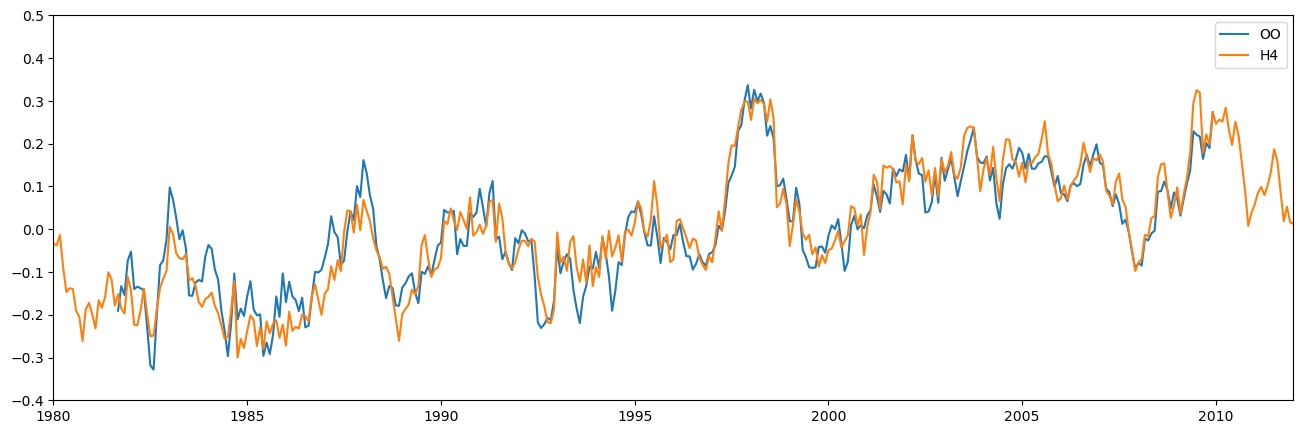

In [16]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, zeroed_oo, label='OO')
plt.plot(h4_time, zeroed_h4, label='H4')
plt.legend()
plt.xlim(1980, 2012)
plt.ylim(-0.4,0.5)

(-0.2, 0.2)

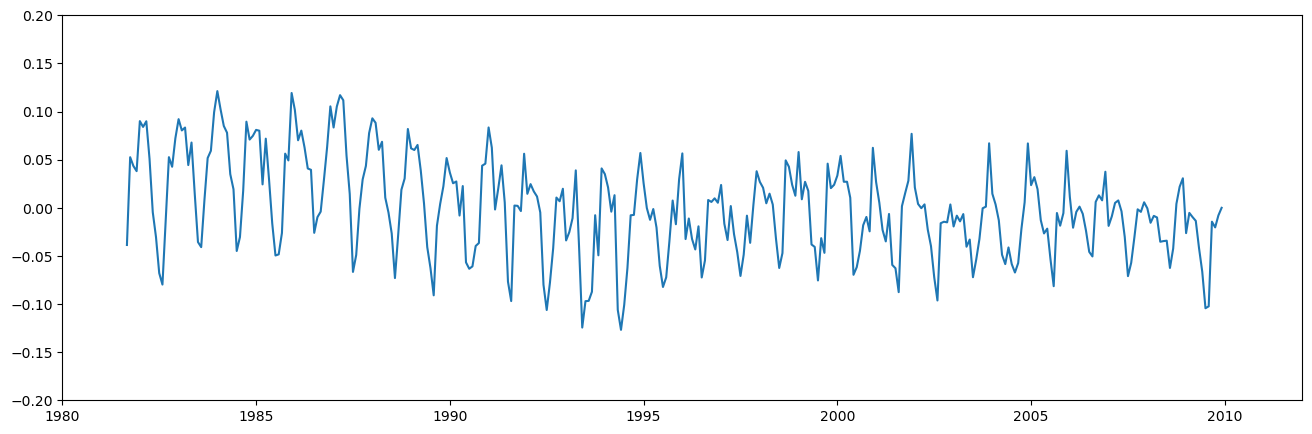

In [17]:
plt.figure()
plt.gcf().set_size_inches(16, 5)
plt.plot(oo_time, difference)
plt.xlim(1980, 2012)
plt.ylim(-0.2,0.2)